<a href="https://colab.research.google.com/github/palanithanarajk/covid_diagnosis/blob/master/covid_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid-19 diagnosis from CT images based on Transfer Learning approach

This tutorial notebook explains about the development of COVID diagnosis system based on `Transfer Learning` of pre-trained deep neural network specifically VGG16. 

This work is inspired from the GitHub repository which could be found in this URL: <https://github.com/UCSD-AI4H/COVID-CT> 

It has the dataset of CT images taken from COVID-19 patients and also Non-COVID subjects. Unlike the original implementation, this tutorial uses VGG16 for transfer learning of COVID features from CT images. 

## Mount Gdrive for the dataset
Download a copy of the dataset and upload into your Google Drive. Then mount the Gdrive for accessing the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


Change the path to your dataset folder 

In [ ]:
import os
os.chdir('gdrive/My Drive/rajudl/covid-gh/')

Check the contents of the folder

In [ ]:
os.listdir()

['covid', 'nonCovid', 'cp.ckpt', 'Copy of malaria_main.ipynb']

Import Libraries such as OpenCV, Numpy, TQDM

In [ ]:
import cv2
import numpy as np
from tqdm import tqdm


Initialize two lists namely 'x' for image data and 'z' for label

In [ ]:
x=[]
z=[]
covid_dir='covid'
noncovid_dir='nonCovid'
img_size=224

Define a function to prepare the dataset as an numpy array

In [ ]:
def train_prepare(img_type,dir):
  for i in tqdm(os.listdir(dir)):
    label=img_type
    path=os.path.join(dir,i)
    img=cv2.imread(path,cv2.IMREAD_COLOR)
    img=cv2.resize(img,(img_size,img_size))
    x.append(np.array(img))
    z.append(label)

create the list related to the Covid images

In [ ]:
train_prepare('covid',covid_dir)

100%|██████████| 349/349 [02:45<00:00,  2.11it/s]


create the list related to the Non Covid images

In [ ]:
train_prepare('nonCovid',noncovid_dir)

100%|██████████| 397/397 [03:01<00:00,  2.19it/s]


Check the otal number for samples

In [ ]:
len(z)

746

Plot few sample images randomly from the prepared list

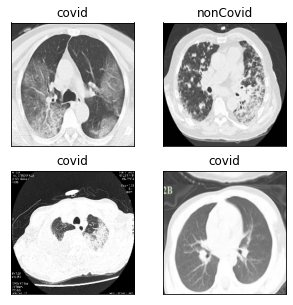

In [ ]:
import matplotlib.pyplot as plt
import random as rn
fig,ax=plt.subplots(2,2)
fig.set_size_inches(5,5)
for i in range(2):
  for j in range(2):
    r=rn.randint(0,len(z))
    ax[i,j].imshow(x[r])
    ax[i,j].set_title(z[r])
    ax[i,j].grid(False)
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])


Normalize the pixel values of the images as well modify the labels so that it is categorial 

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

le=LabelEncoder()
Y=le.fit_transform(z)
Y=to_categorical(Y,2)
X=np.array(x)
X=X/255

Using TensorFlow backend.


Perform a data partition for making the training and test split

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)


Import libraries for deep learning such as Tensorflow and Keras.

Modify the pre-trained neural net, VGG16 for transfer learning.


In [ ]:
# # modelling starts using a CNN.
#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization,GlobalAveragePooling2D
from keras.models import Model

##
#model = Sequential()
#model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (224,224,3)))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
#model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
#model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
#model.add(Flatten())
#model.add(Dense(512))
#model.add(Activation('relu'))
#model.add(Dense(2, activation = "softmax"))
### Pretrained nets
#from keras.applications.densenet import DenseNet121
from keras.applications.vgg16 import VGG16

input_shape=(224, 224, 3)
base_model =VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
# DenseNet121 ,
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False


58892288/58889256 [==============================] - 3s 0us/step


Compile the modified CNN architecture

Fit the compiled model by specifying the batch size and epochs

In [ ]:
import tensorflow as tf
from keras.callbacks import ModelCheckpoint

checkpoint_path = "cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
callback = ModelCheckpoint(filepath=checkpoint_path,monitor='val_accuracy',save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose=1)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)
epochs=20
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

# fits the model on batches with real-time data augmentation:
History=model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),callbacks=[callback],
                  validation_data=(x_test,y_test),  steps_per_epoch=len(x_train) / 32, epochs=epochs)

Epoch 1/20
19/18 [==============================] - 20s 1s/step - loss: 0.6596 - accuracy: 0.6174 - val_loss: 0.5793 - val_accuracy: 0.7467

Epoch 00001: val_accuracy improved from -inf to 0.74667, saving model to cp.ckpt
Epoch 2/20
19/18 [==============================] - 8s 398ms/step - loss: 0.5465 - accuracy: 0.7198 - val_loss: 0.5270 - val_accuracy: 0.7533

Epoch 00002: val_accuracy improved from 0.74667 to 0.75333, saving model to cp.ckpt
Epoch 3/20
19/18 [==============================] - 9s 478ms/step - loss: 0.4763 - accuracy: 0.7802 - val_loss: 0.4972 - val_accuracy: 0.7667

Epoch 00003: val_accuracy improved from 0.75333 to 0.76667, saving model to cp.ckpt
Epoch 4/20
19/18 [==============================] - 9s 473ms/step - loss: 0.4805 - accuracy: 0.7668 - val_loss: 0.4761 - val_accuracy: 0.7933

Epoch 00004: val_accuracy improved from 0.76667 to 0.79333, saving model to cp.ckpt
Epoch 5/20
19/18 [==============================] - 9s 478ms/step - loss: 0.4202 - accuracy: 0.82

Plotting of the accuracy during the training process

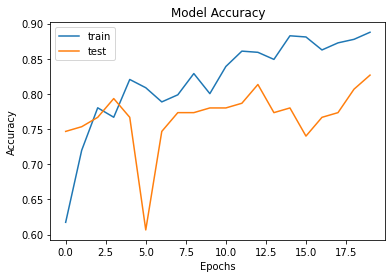

In [ ]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

Evaluate the Trained model

In [ ]:
# Evaluate the model on the test data using `evaluate`
model.load_weights(checkpoint_path)

print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=32)
print("Test Accuracy:", results[1])


Evaluate on test data
150/150 [==============================] - 1s 10ms/step
Test Accuracy: 0.8266666531562805


Save the trained model

In [ ]:
model.save('savedmodel/covid_model') 

Perform predictions using the test dataset

In [ ]:

predictions = model.predict(x_test)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
true_classes=np.argmax(y_test,axis=1)

Compute the performance scores and confusion matrix

In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
report1 = metrics.classification_report(true_classes,predicted_classes)
report2 = metrics.accuracy_score(true_classes,predicted_classes)
print(report1)
print(report2)
confusion_matrix(true_classes,predicted_classes)

              precision    recall  f1-score   support

           0       0.81      0.83      0.82        70
           1       0.85      0.82      0.84        80

    accuracy                           0.83       150
   macro avg       0.83      0.83      0.83       150
weighted avg       0.83      0.83      0.83       150

0.8266666666666667


array([[58, 12],
       [14, 66]])

In [ ]:
Plot the ROC plot

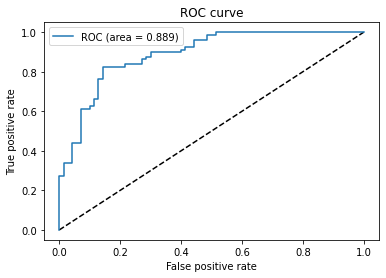

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr_keras, tpr_keras, thresholds_keras = roc_curve(true_classes, predictions[:,1])
auc_rf = auc(fpr_keras, tpr_keras)
auc_rf

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='ROC (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Model Summary

In [ ]:
new_model = tf.keras.models.load_model('savedmodel/my_model')

# Check its architecture
new_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   